In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv
/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv


# Unsupervised Learning Final Project

#### Overview
This dataset is from HELP International, an international humanitarian NGO that is committed to fighting poverty and providing basic amenities and relief during the time of disasters and natural calamities to those affected. Our goal with this model is to categorise the countries using socio-economic and health factors to determine the overall development of the country and see which countries need help the most.

We will be using both k-means clustering and hierarchical clustering to analyze the data and to group similar data points together. K-means clustering divides data into a predefined number of clusters, while hierarchical clustering creates a hierarchical tree-like structure to represent the relationships between the clusters. We will be looking at different metrics such as metrics for health and economy such as life expectancy, health expense, and GDP metrics.

### Exploratory Data Analysis

In [22]:
country = pd.read_csv('/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv')
dictionary = pd.read_csv('/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv')

In [23]:
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [24]:
dictionary.head()

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 100...
2,exports,Exports of goods and services per capita. Give...
3,health,Total health spending per capita. Given as %ag...
4,imports,Imports of goods and services per capita. Give...


In [25]:
# get the number of observations and number of features
num_observations = country.shape[0]
num_features = country.shape[1]

print("Number of Observations:", num_observations)
print("Number of Features:", num_features)
print("Data Information:")
print(country.info())
print("First 5 rows of Data:")
print(country.head())

Number of Observations: 167
Number of Features: 10
Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None
First 5 rows of Data:
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria      

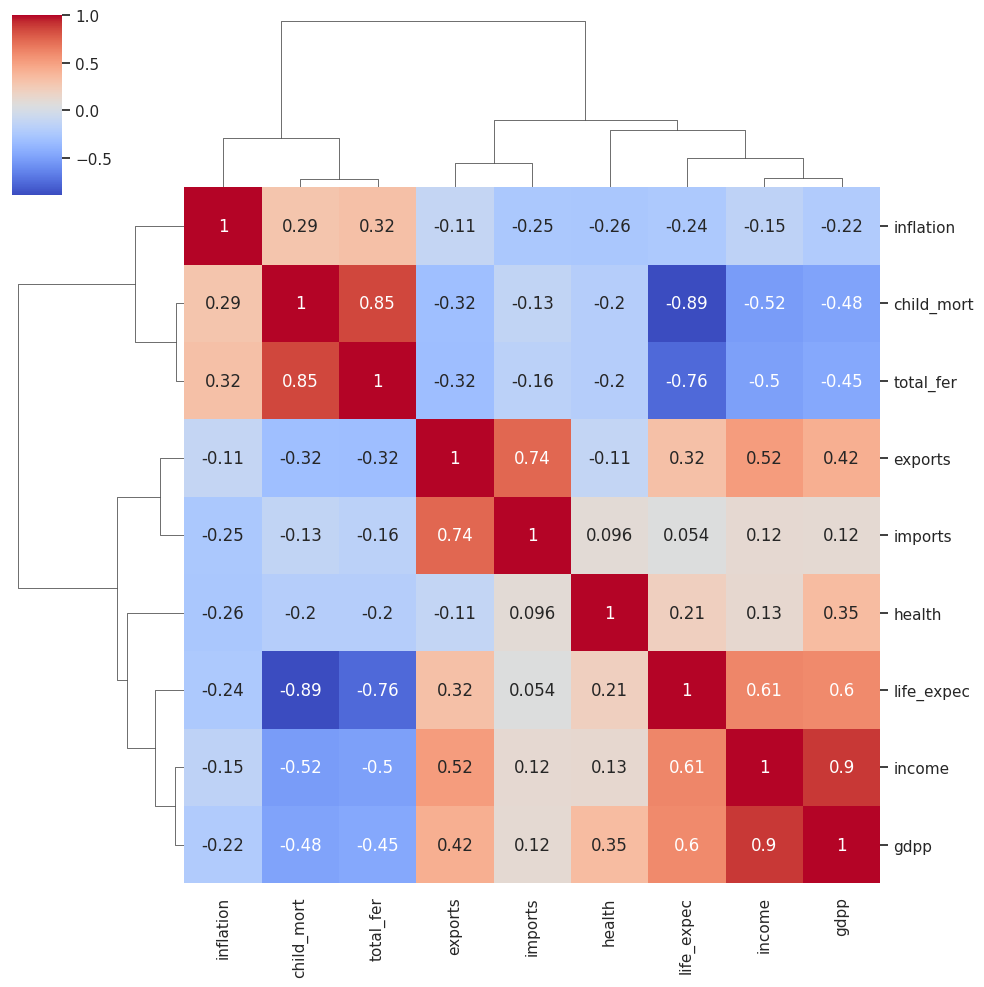

In [26]:
sns.set()
sns.clustermap(country.drop('country', axis = 1).corr(), annot = True, cmap = 'coolwarm',  method = 'ward')

In [27]:
countryx = country.drop('country', axis = 1)

In [28]:
countryx.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


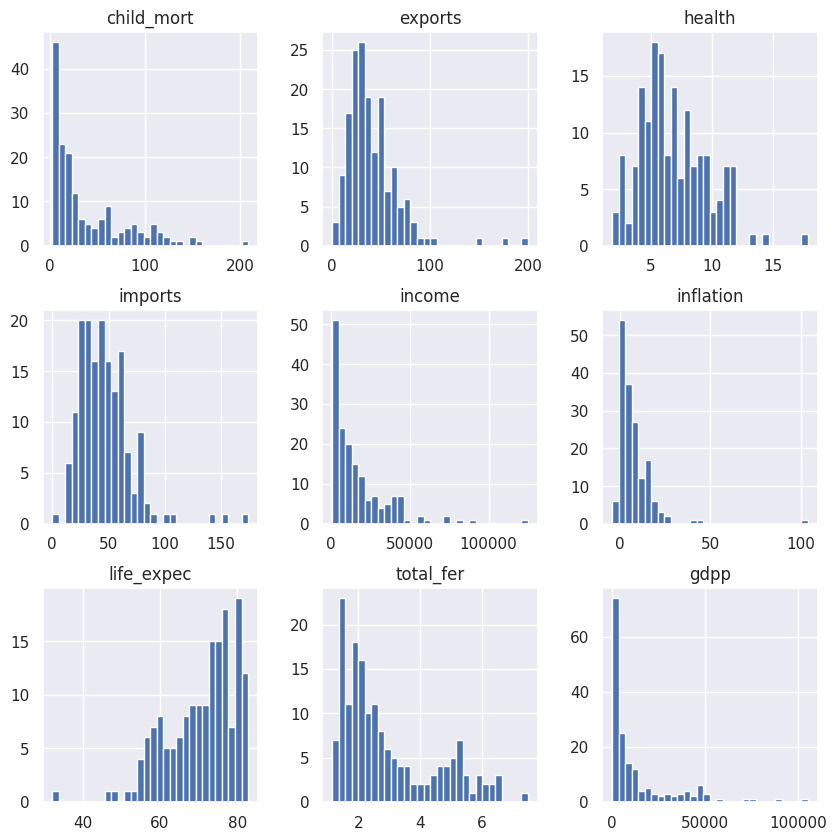

In [29]:
countryx.hist(bins=30,figsize=(10,10));

The dataset covers 167 countries. This means that not all the countries in the world are covered in this dataset as there are currently 195 countries, which makes sense as we are trying to focus on developing countries or countries with humanitarian issues. We can see that a lot of the metrics are skewed. Most are skewed right with the exception of life expectancy (life_expec) which is left skewed. 

### Data Preprocessing

KMeans is very sensitive to scale and requires all features to be on the same scale. KMeans will put more weight or emphasis on features with larger variances and those features will impose more influence on the final cluster shape. 

Additionally, clustering algorithms such as KMeans have a difficult time accurately clustering data of high dimensionality. This is why we will be using PCA to reduce the dimensionality of our data.

In [30]:
# scaling the data
scaler=StandardScaler()
scaler.fit(countryx)
set_scaled=scaler.transform(countryx)

Text(0, 0.5, 'PC2')

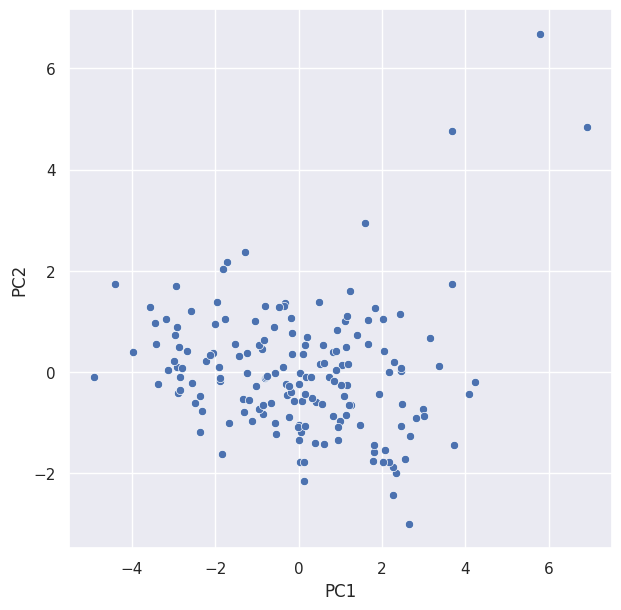

In [31]:
pca=PCA(n_components=2,random_state=0)
x_pca=pca.fit_transform(set_scaled)
data_pca = pd.DataFrame(x_pca)

plt.figure(figsize = (7,7))
sns.scatterplot(x=data_pca[0],y=data_pca[1])
plt.xlabel("PC1")
plt.ylabel("PC2")

### Kmeans Clustering

In [32]:
from sklearn.metrics import silhouette_score
wcss = []
silhouette_coefficients = []
for i in range(2, 16):
    model = KMeans(n_clusters=i)
    model.fit(data_pca)
    wcss.append(model.inertia_) 
    silhouette_coefficients.append(silhouette_score(data_pca, model.labels_))

Text(0.5, 1.0, 'silhouette_score')

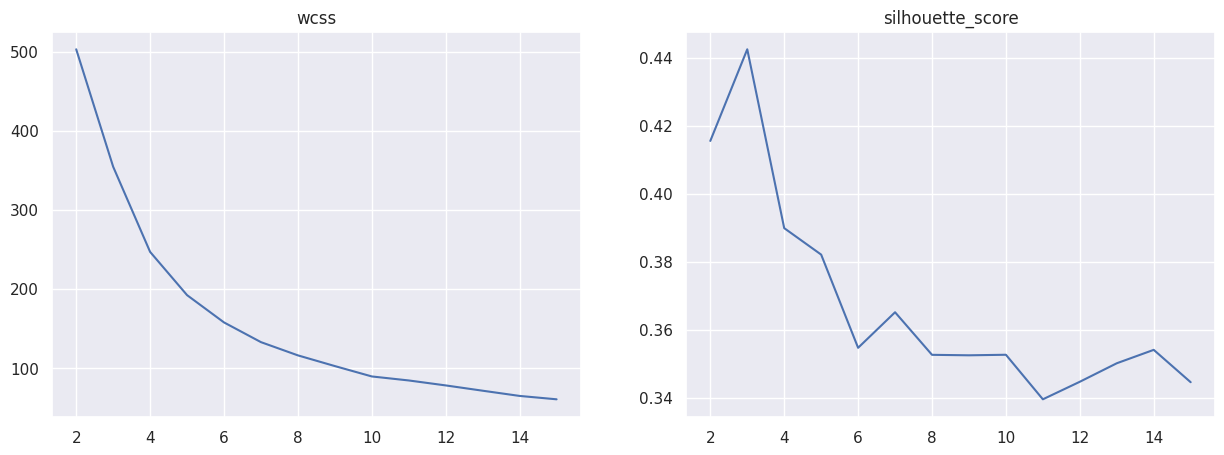

In [33]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.lineplot(x=range(2, 16),y= wcss)
plt.title('wcss')
plt.subplot(122)
sns.lineplot(x=range(2, 16),y=silhouette_coefficients)
plt.title('silhouette_score')

In [34]:
model = KMeans(n_clusters=3) # clusters determined from silhouette score prior
model.fit(data_pca)
y = model.labels_

silhouette_score(data_pca, y)

0.44162993549041984

In [35]:
kmeans=KMeans(n_clusters=3,random_state=3)
kmeans.fit(set_scaled)
# adding predicted Labels to scaled data and original data
countryx["kmean_labels"] = kmeans.predict(set_scaled)
countryx["kmean_labels"].value_counts()
# adding predicted Labels to scaled data and original data
countryx["kmean_labels"] = kmeans.predict(set_scaled)
countryx["kmean_labels"].value_counts()

kmean_labels
1    84
0    47
2    36
Name: count, dtype: int64

In [36]:
# getting mean and median for each variable in the dataset
mean = countryx.groupby("kmean_labels").mean()
median = countryx.groupby("kmean_labels").median()

# Creating dataframe with means and medians 
countryx_kmeans = pd.concat([mean, median], axis=0)
countryx_kmeans.index = ["0_mean", "1_mean", "2_mean", "0_median", "1_median", "2_median"]
countryx_kmeans.T

,0_mean,1_mean,2_mean,0_median,1_median,2_median
child_mort,92.961702,21.927381,5.000000,90.20,18.350,4.200
exports,29.151277,40.243917,58.738889,23.80,37.300,50.350
health,6.388511,6.200952,8.807778,5.66,5.930,9.445
imports,42.323404,47.473404,51.491667,40.30,48.650,39.050
income,3942.404255,12305.595238,45672.222222,1870.00,10180.000,40550.000
inflation,12.019681,7.600905,2.671250,8.92,5.805,1.190
life_expec,59.187234,72.814286,80.127778,59.50,73.600,80.350
total_fer,5.008085,2.307500,1.752778,5.06,2.235,1.815
gdpp,1922.382979,6486.452381,42494.444444,897.00,4670.000,41200.000


We got a silhouette score of 0.55, which is pretty good! Now, let's see if hierarchical clustering will show us anything different.

### Hierarchical Clustering

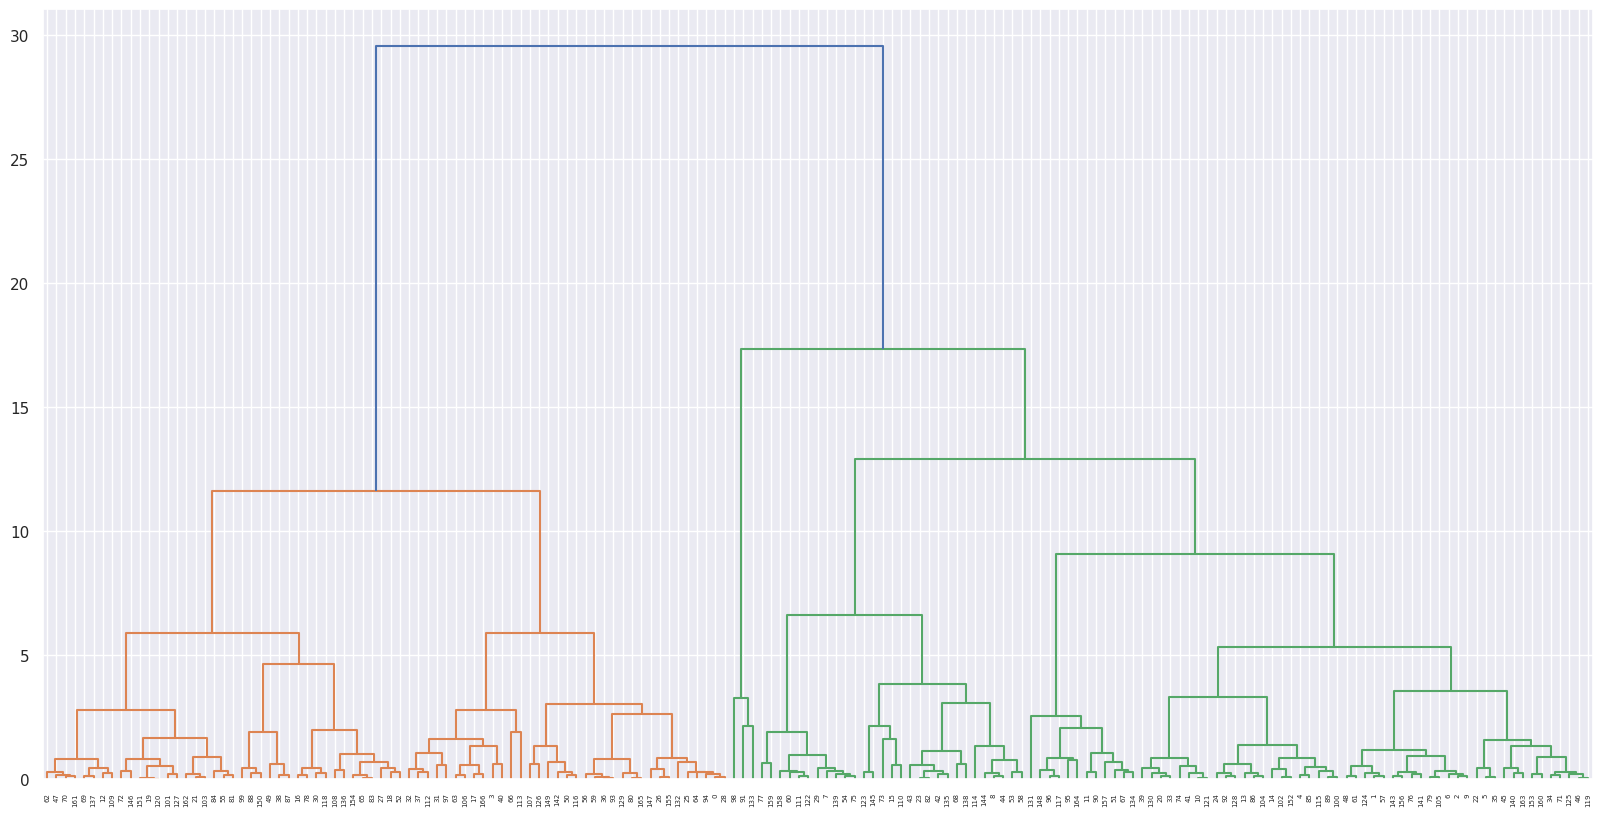

In [37]:
plt.figure(figsize=(20, 10))
fig = hierarchy.dendrogram(hierarchy.linkage(y=data_pca, method='ward'))

<Axes: >

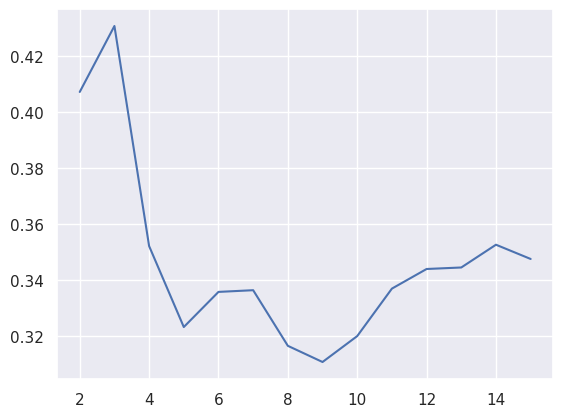

In [38]:
silhouette_coefficients2 = []
for i in range(2, 16):
    hi = AgglomerativeClustering(n_clusters = i)
    hi.fit(data_pca)
    silhouette_coefficients2.append(silhouette_score(data_pca, hi.labels_))

sns.lineplot(x=range(2, 16),y=silhouette_coefficients2)

In [39]:
heira = AgglomerativeClustering(n_clusters = 3)
heira.fit(data_pca)
y = heira.labels_

silhouette_score(data_pca,y)

0.4308434627918911

In [40]:
countryx=countryx.drop("kmean_labels",axis=1)
agg=AgglomerativeClustering(n_clusters=3,linkage="complete")
# Adding predicted Labels to scaled data and original data
countryx["Agg_labels"] = agg.fit_predict(set_scaled)
countryx["Agg_labels"].value_counts()

# getting mean and median for each variable in the dataset
mean = countryx.groupby("Agg_labels").mean()
median = countryx.groupby("Agg_labels").median()
# Creating dataframe with means and medians 
data_agg = pd.concat([mean, median], axis=0)
data_agg.index = ["0_mean", "1_mean", "2_mean", "0_median", "1_median", "2_median"]
data_agg.T

,0_mean,1_mean,2_mean,0_median,1_median,2_median
child_mort,82.229091,17.028440,4.133333,80.30,11.70,2.80
exports,31.407636,42.291550,176.000000,25.30,38.40,175.00
health,6.631273,6.909358,6.793333,5.69,6.84,7.77
imports,48.534545,43.039137,156.666667,44.90,41.20,154.00
income,3812.236364,22581.559633,64033.333333,2180.00,16500.00,72100.00
inflation,10.655000,6.478321,2.468000,6.39,4.22,3.62
life_expec,60.554545,75.302752,81.433333,60.70,76.00,81.30
total_fer,4.717818,2.098073,1.380000,4.95,1.95,1.36
gdpp,1917.709091,17310.458716,57566.666667,1000.00,9070.00,46600.00


## Conclusion

A Kmeans algorithm and hierarchical clustering algorithm were applied to the nine numerical features of the data set and the countries were partitioned into three distinct clusters. The clusters are visualized by the highest two contributing dimensions of a principal component analysis and mean metrics of the nine variables were calculated for each cluster and the cluster assignment value was appended to the original data set for the benefit of further analysis.

Cluster 2 seems to be countries that are doing better financially and socially as it has the best average metrics for our features. This group shows a mean child mortality rate at 4, mean income at $64k and average life expectancy of around 80.

Cluster 1 appears to consist of countries doing worse than cluster 2 yet also shows promising average metrics in most features. Income is $24k and average life expectancy is 76. Inflation is quite high at almost 6% and the child mortality rate is 3 times as much at cluster 2's at 12. 

The third group displays the worst average values for almost all of our features. Cluster 0 has higheset child mortality rate of 77, the highest inflation at 10%, and the lowest income at around $4k. In comparison, the child mortality rate is almost 20 times higher and the income is less than 10% that of cluster 1.

Given our original goal of identifying countries that would benefit the most from HELP International's help, I think it is clear that they wouldn't go wrong with taking a closer look at countries from cluster 0.